In [11]:
import utils_data
import utils_run 
import models
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

## Fitting Logistic Regression by MLE

Through the following toy example, we will demonstrate one important drawback of training classifiers by minimizing the negative log-likelihood. Specifically, this becomes apparent when the classifier is tested on test data drawn from a different distribution than the training data. In such cases, a classifier like logistic regression might make very confident predictions on out-of-distribution data despite the fact that it has not been trained on such data. This may have very negative consequences in safety-critical applications.

In [12]:
#create the data
train_data = utils_data.create_data(
        create_data_functions=[
            utils_data.create_data_mixture_of_gaussians,
        ],
        functions_args=[
            utils_data.mog_three_in_distribution_one_out
        ])

In [15]:
#split to train and test data
labels_numpy = train_data['targets'].numpy()
samples_numpy = train_data['samples'].numpy()
train_labels_idx = np.where(labels_numpy != 3)[0]
test_labels_idx = np.where(labels_numpy == 3)[0]
x_train_np = samples_numpy[train_labels_idx]
y_train_np = labels_numpy[train_labels_idx]
x_test_np = samples_numpy[test_labels_idx]

### Training data vs Out-of-distribution

Below, we have created a training set made from 3 gaussian clusters with equidistant means and isotropic covariance matrices, each representing one of the three possible classes. The yellow cluster is another gaussian cluster far from training data which we consider out-of-distribution and for which the labels are not known. Given that a logistic regression model has been trained given only data from the three clusters representing each class, we want to see its behaviour when given test data which do not resemble training data.

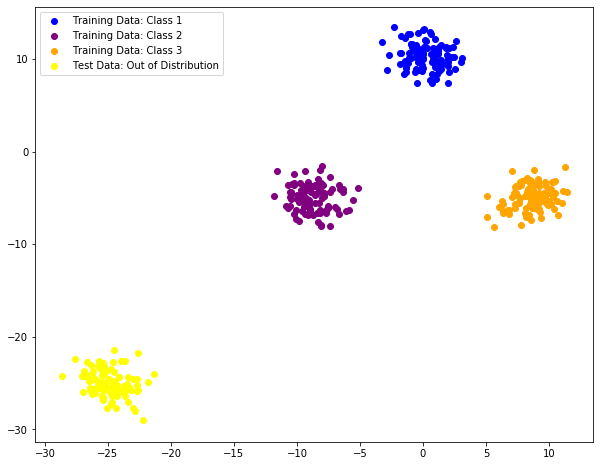

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(x_train_np[y_train_np==0][:,0], x_train_np[y_train_np==0][:,1], c='blue', label='Training Data: Class 1')
plt.scatter(x_train_np[y_train_np==1][:,0], x_train_np[y_train_np==1][:,1], c='purple', label='Training Data: Class 2')
plt.scatter(x_train_np[y_train_np==2][:,0], x_train_np[y_train_np==2][:,1], c='orange', label='Training Data: Class 3')
plt.scatter(x_test_np[:,0], x_test_np[:,1], c='yellow', label='Test Data: Out of Distribution')
plt.legend()

In [16]:
x_train = torch.Tensor(x_train_np)
y_train = torch.Tensor(y_train_np).to(torch.int64)
x_test = torch.Tensor(x_test_np)

In [17]:
model = models.LR()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot()

In [18]:
#fitting the model
model, optimizer, training_loss = utils_run.train_LR(
    model=model,
    optimizer=optimizer,
    n_epochs=500,
    batch_size=32,
    x_train=x_train,
    labels=y_train
)

Below, we have printed 

### Model predictions

Below, we have printed the probability for each class predicted by the model for each point of the OOD test data. It is evident that the model predicts Class 2 with maximum confidence (100%) for every point of the test data, since Class 2 points form the closest cluster.

In [20]:
#making predictions on test data
test_preds = model(x_test)
test_preds

tensor([[2.8712e-13, 1.0000e+00, 3.6322e-12],
        [4.5307e-14, 1.0000e+00, 6.7453e-13],
        [4.0292e-14, 1.0000e+00, 3.3412e-12],
        [5.1898e-14, 1.0000e+00, 7.6620e-12],
        [1.3746e-14, 1.0000e+00, 2.3858e-12],
        [1.3840e-13, 1.0000e+00, 4.8419e-13],
        [5.4442e-14, 1.0000e+00, 1.2168e-11],
        [1.8592e-14, 1.0000e+00, 2.2556e-11],
        [9.1856e-14, 1.0000e+00, 4.7763e-12],
        [2.4231e-12, 1.0000e+00, 5.6993e-11],
        [4.6128e-14, 1.0000e+00, 1.2437e-12],
        [1.0429e-13, 1.0000e+00, 3.3909e-11],
        [3.9659e-14, 1.0000e+00, 1.0843e-12],
        [2.2790e-13, 1.0000e+00, 3.7612e-12],
        [1.9224e-14, 1.0000e+00, 1.0332e-12],
        [5.8247e-14, 1.0000e+00, 1.6578e-12],
        [1.1464e-14, 1.0000e+00, 3.8583e-11],
        [4.0116e-14, 1.0000e+00, 3.1827e-12],
        [1.2072e-14, 1.0000e+00, 5.7768e-12],
        [1.8187e-14, 1.0000e+00, 2.4624e-12],
        [7.5638e-13, 1.0000e+00, 1.9412e-11],
        [4.2230e-14, 1.0000e+00, 2

### Uncertainty in predictions

Below, we visualized the behaviour of the model by calculating the entropy of the predicted probabilities vector on a grid of points, which is a measure of the total uncertainty in the predictions of a model. As we can see the model makes very confident predictions ever far away from data (entropy is very low). The model makes uncertain predictions (high entropy) only in between the classes as well as in the middle of the data. 

Hence, the model does not account for distributional uncertainty. In other words, if the model is given test data which are drawn from the same distribution as training data, it will still make very confident predictions (low entropy probabilities vector) which may well be utterly wrong.

In [19]:
#please run this cell to generate interactive 3D plot
utils_run.plot_decision_surface_LR(model=model,
                                   x_train=train_data['samples'],
                                   labels_train=train_data['targets']
                                  )

## Dirichlet Prior Network

### Toy Example

Below, we are fitting a Dirichlet Prior Network to the same training data and visualize its behaviour both in regions of in and out of distribution data. 

The model makes condifent predictions (low-entropy) in regions dominated by each class. However, the model makes totally uncertain predictions in the region where we defined that data are out-of-distribution. On this region, as well as in the rest of regions between the classes and away from training data, the entropy takes its maximum value. In other words, the Prior Network assigns a probability of 1/3 to each class, which is a more rational decision given that data from such regions are assumed to be out-of-distribution and we cannot be certain of the class they belong to.

The fourth figure is a plot of the Mutual Information between the label and the expected categorical predicted by the network. As mentioned in the paper, this is a measure of the distributional uncertainty. Particularly, it is the difference between the total uncertainty and the expected data uncertainty. As it can be observed, the mutual information curve has similar shape to the entropy curve. However, the mutual information is zero in the middle of the three classes, since the uncertainty in this region arises due to class overlap and not due to the fact that this region is considered out-of-distribution.

In [57]:
#please run this cell to generate interactive 3D plot
test_data = train_data
args = utils_run.create_args()
model, optimizer, loss_fn = utils_run.setup(
        args=args,
        in_dim=train_data['samples'].shape[1],
        out_dim=train_data['concentrations'].shape[1])

model, optimizer, training_loss = utils_run.train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=args.n_epochs,
    batch_size=args.batch_size,
    x_train=train_data['samples'],
    target_concentrations=train_data['concentrations'])

accuracy, pred_proba, pred_class = utils_run.eval_model(
    model=model,
    x_test=test_data['samples'],
    y_test=test_data['concentrations'])

utils_run.plot_results(
    train_samples=train_data['samples'],
    labels_train=train_data['targets'],
    train_concentrations=train_data['concentrations'],
    model=model,
    training_loss=training_loss)

## Experiments with different OOD shapes

### OOD as a ring around the data

To train a Prior Network, the multi-task objective defined in the paper, requires samples from the out-of-domain distribution. In practical terms, this is unknown and samples are unavailable. One solution is to synthetically generate points on the boundary of the in-domain region. In two dimensions where data can be visualized, this is possible. A sensible choice is to create an out-of-domain distribution which forms a ring around the training data. As a result, any test data on our out of the ring are assumed to be out-of-distribution.

By osberving the entropy and the mutual information plots, it is evident  that the model makes confident predictions within the ring (entropy is minimized apart from the center where classes overlap), whereas the model makes uncertain predictions outside the ring (entropy and mutual informaation are maximized).

In [37]:
#create the data
train_data_ring = utils_data.create_data(
    create_data_functions=[
        utils_data.create_data_spherical_shells,
        utils_data.create_data_mixture_of_gaussians,
    ],
    functions_args=[
        utils_data.rings,
        utils_data.mog_three_in_distribution_overlap
    ])
test_data_ring = train_data_ring

In [49]:
#please run this cell to generate interactive 3D plot
args = utils_run.create_args()
model, optimizer, loss_fn = utils_run.setup(
        args=args,
        in_dim=train_data_ring['samples'].shape[1],
        out_dim=train_data_ring['concentrations'].shape[1])

model, optimizer, training_loss = utils_run.train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=args.n_epochs,
    batch_size=args.batch_size,
    x_train=train_data_ring['samples'],
    target_concentrations=train_data_ring['concentrations'])

accuracy, pred_proba, pred_class = utils_run.eval_model(
    model=model,
    x_test=test_data_ring['samples'],
    y_test=test_data_ring['concentrations'])

utils_run.plot_results(
    train_samples=train_data_ring['samples'],
    labels_train=train_data_ring['targets'],
    train_concentrations=train_data_ring['concentrations'],
    model=model,
    training_loss=training_loss)

### Interpolation: OOD in the middle of the data

In other cases, we might not have any data in the region in between the classes. Consequently, we may want our classifier to refrain from making confident predictions in this region since without any data, we are quite uncertain of the class that these cases belong to. 

Hence, we can generate points from within the inner boundary of the in-domain region to form the OOD data needed to train a Prior Network. The resulting model is now uncertain both when extrapolating and when interpolating. This is confirmed by the fact that both the entropy and the mutual information are maximized in regions between the classes and far away from training data as well as in the middle of the three classes, a region which we specifically assumed to be out-of-distribution.

In [52]:
train_data_interpolation = utils_data.create_data(
    create_data_functions=[
        #utils_data.create_data_spherical_shells,
        utils_data.create_data_mixture_of_gaussians,
    ],
    functions_args=[
        #utils_data.rings,
        utils_data.mog_ood_in_middle_no_overlap
    ])
test_data_interpolation = train_data_interpolation

In [56]:
#please run this cell to generate interactive 3D plot
args = utils_run.create_args()
model, optimizer, loss_fn = utils_run.setup(
        args=args,
        in_dim=train_data_interpolation['samples'].shape[1],
        out_dim=train_data_interpolation['concentrations'].shape[1])

model, optimizer, training_loss = utils_run.train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=2000,
    batch_size=args.batch_size,
    x_train=train_data_interpolation['samples'],
    target_concentrations=train_data_interpolation['concentrations'])

accuracy, pred_proba, pred_class = utils_run.eval_model(
    model=model,
    x_test=test_data_interpolation['samples'],
    y_test=test_data_interpolation['concentrations'])

utils_run.plot_results(
    train_samples=train_data_interpolation['samples'],
    labels_train=train_data_interpolation['targets'],
    train_concentrations=train_data_interpolation['concentrations'],
    model=model,
    training_loss=training_loss)